In [22]:
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)# prerequisites
import torch
import torch.nn as nnfashion_
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torchvision.utils import save_image


In [23]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.FashionMNIST(root='./fashion_mnist_data/', train=True, transform=transform, download=False)
test_dataset = datasets.FashionMNIST(root='./fashion_mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [24]:
sample = next(iter(train_loader))

imgs, lbls = sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image tensor: torch.Size([100, 1, 28, 28])
class labels: tensor([0, 7, 5, 1, 8, 1, 0, 8, 3, 7, 5, 0, 5, 9, 3, 7, 2, 4, 4, 7, 1, 0, 7, 9, 4, 9, 3, 5, 0, 0, 3, 9, 6, 8, 8, 7, 5,
        3, 2, 4, 5, 3, 3, 8, 6, 3, 8, 2, 5, 8, 9, 3, 3, 2, 2, 7, 8, 4, 1, 8, 6, 2, 5, 2, 4, 1, 0, 2, 4, 3, 9, 3, 3, 2,
        4, 5, 9, 3, 2, 8, 1, 4, 2, 7, 2, 9, 4, 6, 4, 6, 5, 4, 3, 0, 1, 5, 1, 0, 1, 2])


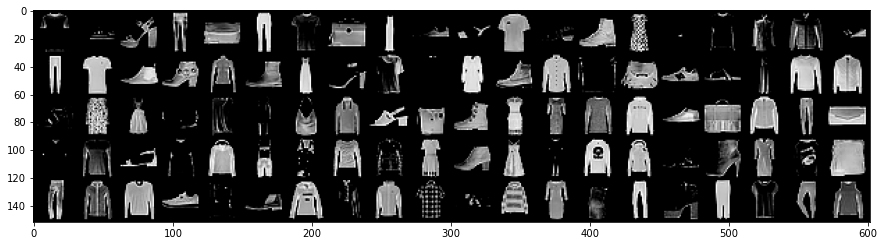

In [25]:
# create a grid 
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [26]:
# define some helper functions
def get_item(preds, labels):
    """function that returns the accuracy of our architecture"""
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad() # turn off gradients during inference for memory effieciency
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    model = network
    for batch in dataloader:
        images, labels = batch
        preds = model(images) # get preds
        all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis
        
    return all_preds


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [27]:
# define network

class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.batchN1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.batchN2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
        
        
    def forward(self, t): # implements the forward method (flow of tensors)
        
        # hidden conv layer 
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        t = self.batchN1(t)
        
        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        
        # flatten
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.batchN2(t)
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        
        return t       

In [28]:
cnn_model = Network() # init model
print(cnn_model) # print model structure

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (batchN2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [31]:
optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
# def train loop

for epoch in range(5):
    start_time = time.time()
    total_correct = 0
    total_loss = 0
    for batch in train_loader:
        imgs, lbls = batch
        preds = cnn_model(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # compute loss
        optimizer.zero_grad() # zero grads
        loss.backward() # calculates gradients 
        optimizer.step() # update the weights
        
        total_loss += loss.item()
        total_correct += get_item(preds, lbls)
        accuracy = total_correct/len(train_dataset)
    end_time = time.time() - start_time    
    print("Epoch no.",epoch+1 ,"|accuracy: ", round(accuracy, 3),"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")

Epoch no. 1 |accuracy:  0.895 % |total_loss:  169.60643950849771 | epoch_duration:  19.31 sec
Epoch no. 2 |accuracy:  0.9 % |total_loss:  161.7508704289794 | epoch_duration:  18.75 sec
Epoch no. 3 |accuracy:  0.904 % |total_loss:  155.69489755481482 | epoch_duration:  19.06 sec
Epoch no. 4 |accuracy:  0.907 % |total_loss:  149.9197400957346 | epoch_duration:  21.01 sec
Epoch no. 5 |accuracy:  0.909 % |total_loss:  145.93359006941319 | epoch_duration:  20.25 sec


In [32]:
# get all preds
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=train_dataset, num_workers=1)
all_preds= get_all_preds(network=cnn_model, dataloader=pred_data_loader) 

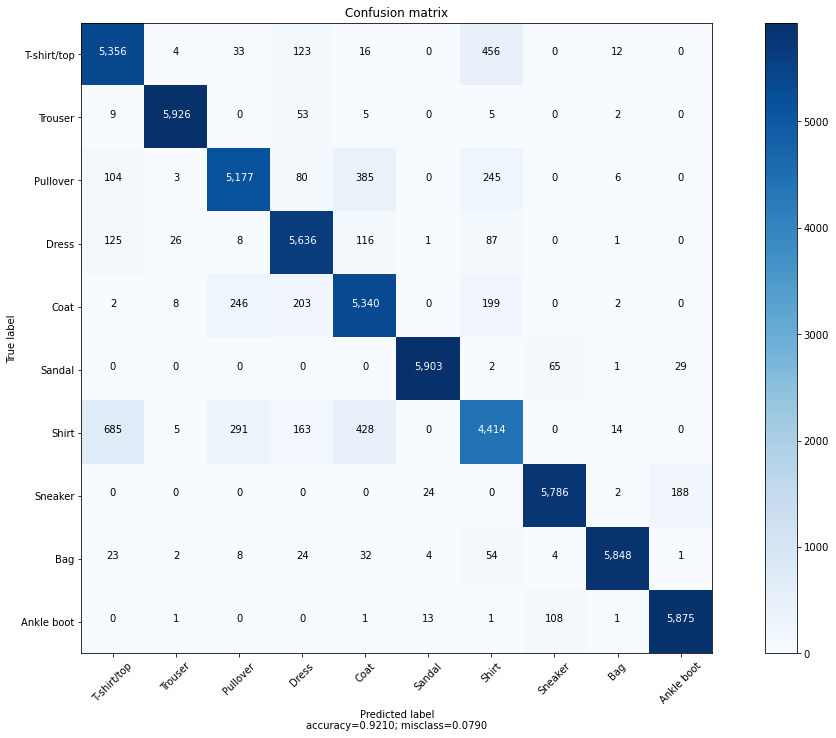

In [33]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(y_true=train_dataset.targets, y_pred=all_preds.argmax(1)), target_names=train_dataset.classes, normalize=False)